<p>&nbsp;</p>
</p><h1 style="text-align: center;"><strong>Sentiment Analysis on Reddit News Headlines</strong></h1>
<h2 style="text-align: center;"><strong>with Python’s Natural Language Toolkit (NLTK)</strong></h2>
<p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p>

# Introduction

**Imports and Parameters:**

In [30]:
import matplotlib.pyplot as plt
from IPython import display     # iPython module - which will let us control the clearing of printed output inside loops
from pprint import pprint       # pprint - which lets us "pretty-print" JSON and lists
import seaborn as sns
import pandas as pd
import numpy as np
import math
import nltk

sns.set(style='darkgrid', context='talk', palette='Dark2')

****

# Reddit API via PRAW

For this tutorial, we'll be using a Reddit API wrapper, called `praw`, to loop through the /r/politics subreddit headlines.

In [31]:
import praw

reddit = praw.Reddit(client_id='WA4ptzXj2IjTPA',
                     client_secret='dodxB_R6SFQy2eN5eyhZV1Fq8wU',
                     user_agent='Bcould')

**Let's define a set for our headlines so we don't get duplicates when running multiple times:**

In [34]:
headlines = set()

**Now, we can iterate through the /r/politics subreddit using the API client:**

In [35]:
for submission in reddit.subreddit('politics').new(limit=None):
    headlines.add(submission.title)
    display.clear_output()
    print(len(headlines))

936


We're iterating over the "new" posts in /r/politics, and by setting the limit to None we can get up to 1000 headlines.

***

**INSTALLATION**

APPEARED: Error message with nltk.sentiment.vader in Python

**To resolve the problem, run the installation:**

In [6]:
import nltk
nltk.downloader.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bruno\AppData\Roaming\nltk_data...


True

**END INSTALLATION**

***

# Labeling data

NLTK’s built-in Vader Sentiment Analyzer will simply rank a piece of text as positive, negative or neutral using a lexicon of positive and negative words.

We can utilize this tool by first creating a Sentiment Intensity Analyzer (SIA) to categorize our headlines, then we'll use the polarity_scores method to get the sentiment.

**Attaching each feelings dictionary to a list of results, we'll transform into a dataframe:**

In [36]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

pprint(results[:3], width=100)

[{'compound': 0.4019,
  'headline': 'The Local Role Of Third Parties In The 2018 Midterms',
  'neg': 0.0,
  'neu': 0.769,
  'pos': 0.231},
 {'compound': 0.5574,
  'headline': 'Supreme Court Stays Out of Secret Case That May Be Part of Mueller Probe',
  'neg': 0.0,
  'neu': 0.783,
  'pos': 0.217},
 {'compound': 0.25,
  'headline': "Cyntoia Brown Was Granted Clemency by Tennessee's Governor",
  'neg': 0.0,
  'neu': 0.778,
  'pos': 0.222}]


**DataFrame:**

In [41]:
df = pd.DataFrame.from_records(results)
df.head()

,compound,headline,neg,neu,pos
0,0.4019,The Local Role Of Third Parties In The 2018 Mi...,0.0,0.769,0.231
1,0.5574,Supreme Court Stays Out of Secret Case That Ma...,0.0,0.783,0.217
2,0.2500,Cyntoia Brown Was Granted Clemency by Tennesse...,0.0,0.778,0.222
3,0.0000,White House reverses course on food stamp fund...,0.0,1.000,0.000
4,0.0000,"Starting today, ex-felons can sign up to vote ...",0.0,1.000,0.000


Our dataframe consists of four columns from the sentiment scoring: `Neu`, `Neg`, `Pos` and `compound`.

The first three represent the sentiment score percentage of each category in our headline, and the compound single number that scores the sentiment. `compound` ranges from -1 (Extremely Negative) to 1 (Extremely Positive).

**Score:**

We will consider posts with a compound value greater than 0.2 as positive and less than -0.2 as negative. There's some testing and experimentation that goes with choosing these ranges, and there is a trade-off to be made here. If you choose a higher value, you might get more compact results (less false positives and false negatives), but the size of the results will decrease significantly.

Creating:
- Positive label of 1 if `compound` is greater than 0.2.
- Negative label of -1 if `compound` is less than -0.2.
- Everything else will be 0.

In [42]:
df['label'] = 0
df.loc[df['compound'] > 0.2, 'label'] = 1
df.loc[df['compound'] < -0.2, 'label'] = -1
df.head()

,compound,headline,neg,neu,pos,label
0,0.4019,The Local Role Of Third Parties In The 2018 Mi...,0.0,0.769,0.231,1
1,0.5574,Supreme Court Stays Out of Secret Case That Ma...,0.0,0.783,0.217,1
2,0.2500,Cyntoia Brown Was Granted Clemency by Tennesse...,0.0,0.778,0.222,1
3,0.0000,White House reverses course on food stamp fund...,0.0,1.000,0.000,0
4,0.0000,"Starting today, ex-felons can sign up to vote ...",0.0,1.000,0.000,0


**We have all the data we need to save, so let's do that:**

In [43]:
df2 = df[['headline', 'label']]

**Attaching the data to a csv file:**

In [44]:
df2.to_csv('reddit_headlines_labels.csv', mode='a', encoding='utf-8', index=False)

In [45]:
df.label.value_counts()

 0    404
-1    330
 1    202
Name: label, dtype: int64

NOTE: Make sure that if you redesign the headlines, you can get duplicates. Maybe add a more advanced save function that reads and removes duplicates before saving.

***

# Dataset Info and Statistics

**Observing positive and negative headlines:**

In [46]:
print("Positive headlines:\n")
pprint(list(df[df['label'] == 1].headline)[:5], width=200)

print("\nNegative headlines:\n")
pprint(list(df[df['label'] == -1].headline)[:5], width=200)

Positive headlines:

['The Local Role Of Third Parties In The 2018 Midterms',
 'Supreme Court Stays Out of Secret Case That May Be Part of Mueller Probe',
 "Cyntoia Brown Was Granted Clemency by Tennessee's Governor",
 'Felon voting rights could be restored, unless Governor-Elect DeSantis puts a hold on Amendment 4',
 'Donald Trump Was Just Handed a Chance to Supercharge Voter Suppression in 2020']

Negative headlines:

['Fitch warns an extended shutdown could hurt the U.S. credit rating',
 'The Battle Over NAFTA 2.0 Has Just Begun',
 'For Trump adviser Roger Stone, an uncomfortable legal limbo persists',
 "After decades of waiting, felony convictions won't stop Jacksonville's newest voters",
 'Your fact-checking cheat sheet for Trump’s immigration address']


**How many positives and total negatives exist in this dataset:**

In [47]:
df.label.value_counts(normalize=True) * 100

 0    43.162393
-1    35.256410
 1    21.581197
Name: label, dtype: float64

The first line gives us raw value counts of the labels, whereas the second line provides percentages with the normalize keyword

**Visualization:**

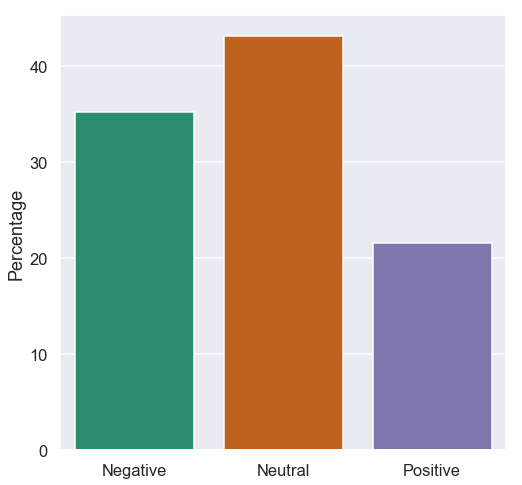

In [48]:
fig, ax = plt.subplots(figsize=(8, 8))

counts = df.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show()

The large number of neutral headlines is due to two main reasons:

    1. The assumption that we made earlier where headlines with compound value between 0.2 and -0.2 are considered neutral. The higher the margin, the larger the number of neutral headlines.
	2. We used general lexicon to categorize political news. The more correct way is to use a political-specific lexicon, but for that we would either need a human to manually label data, or we would need to find a custom lexicon already made.
    
Another interesting observation is the number of negative headlines, which could be attributed to the media’s behavior, such as the exaggeration of titles for clickbait. Another possibility is that our analyzer produced a lot of false negatives.

***

# Tokenizers and Stopwords

**TOKENIZER:**

Tokenization is the process of breaking a stream of text up into meaningful elements called tokens. You can tokenize a paragraph into sentences, a sentence into words and so on.

**In this case, we have titles, which can be considered sentences, so we will use a word tokenizer:**

In [50]:
from nltk.tokenize import word_tokenize, RegexpTokenizer

example = "This is an example sentence! However, it isn't a very informative one"

print(word_tokenize(example, language='english'))

['This', 'is', 'an', 'example', 'sentence', '!', 'However', ',', 'it', 'is', "n't", 'a', 'very', 'informative', 'one']


**If you need to remove punctuation or use another tokenizer that only looks for words like this:**

In [51]:
tokenizer = RegexpTokenizer(r'\w+')
print(tokenizer.tokenize(example))

['This', 'is', 'an', 'example', 'sentence', 'However', 'it', 'isn', 't', 'a', 'very', 'informative', 'one']


There's quite a few tokenizers, and you can view them all [here](http://www.nltk.org/api/nltk.tokenize.html). There's probably one that fits the bill more than others. The `TweetTokenizer` is a good example.

**STOPWORDS:**

In the above tokens you'll also notice that we have a lot of words like ’the, ’is’, ’and’, ’what’, etc. that are somewhat irrelevant to text sentiment and don't provide any valuable information. These are called stopwords.

**Taking a simple stopwords list from NLTK:**

In [52]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
print(stop_words[:20])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


***

# Word Distributions

Let's start by creating a function that will read a list of headlines and perform lowercasing, tokenizing, and stopword removal:

**Function:**

In [53]:
def process_text(headlines):
    tokens = []
    for line in headlines:
        line = line.lower()
        toks = tokenizer.tokenize(line)
        toks = [t for t in toks if t not in stop_words]
        tokens.extend(toks)
    
    return tokens

## Positive Words

We can grab all of the positive label headlines from our dataframe, hand them over to our function, then call NLTK's `FreqDist` function to get the most common words in the positive headlines:

**Positive Headlines:**

In [55]:
pos_lines = list(df[df.label == 1].headline)

pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(20)

[('trump', 66),
 ('court', 20),
 ('supreme', 19),
 ('health', 19),
 ('care', 19),
 ('border', 17),
 ('justice', 17),
 ('mueller', 16),
 ('new', 16),
 ('shutdown', 14),
 ('wall', 14),
 ('russian', 13),
 ('democrats', 13),
 ('says', 12),
 ('rosenstein', 11),
 ('security', 11),
 ('case', 10),
 ('leave', 10),
 ('mystery', 10),
 ('rights', 9)]

**Visualization:**

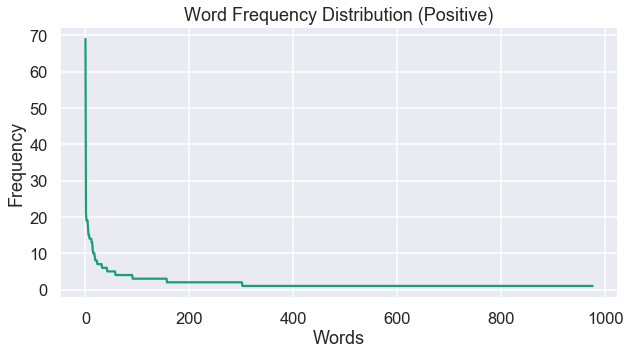

In [22]:
y_val = [x[1] for x in pos_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive)")
plt.show()

The above chart is showing the frequency patterns, where the y-axis is the frequency of the words and in x-axis is the words ranked by their frequency. So, the most frequent word, which in our case is ‘trump’, is plotted at (1,74).

For some of you, that plot may seem a bit familiar. That’s because it’s seems to be following the power-law distribution. So, to visually confirm it, we can use a log-log plot:

**Visualization:**

**log-log plot:**

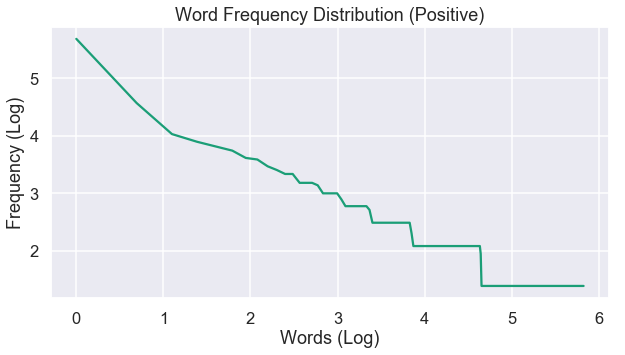

In [56]:
y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
    y_final.append(math.log(i + k + z + t))

x_val = [math.log(i + 1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Positive)")
plt.plot(x_val, y_final)
plt.show()

As expected, an almost straight line with a heavy tail (noisy tail). This shows that our data fits under the Zipf’s Law. In other words, the above plot shows that in our word distribution a vast minority of the words appear the most, while the majority of words appear less.

## Negative Words

**Process the negative text data:**

In [57]:
neg_lines = list(df2[df2.label == -1].headline)

neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)

neg_freq.most_common(20)

[('trump', 164),
 ('border', 53),
 ('shutdown', 50),
 ('emergency', 37),
 ('wall', 34),
 ('national', 24),
 ('u', 18),
 ('government', 17),
 ('says', 15),
 ('crisis', 14),
 ('president', 13),
 ('lies', 13),
 ('democrats', 12),
 ('would', 12),
 ('house', 12),
 ('bill', 12),
 ('gop', 11),
 ('russian', 11),
 ('new', 11),
 ('mueller', 11)]

**Visualization:**

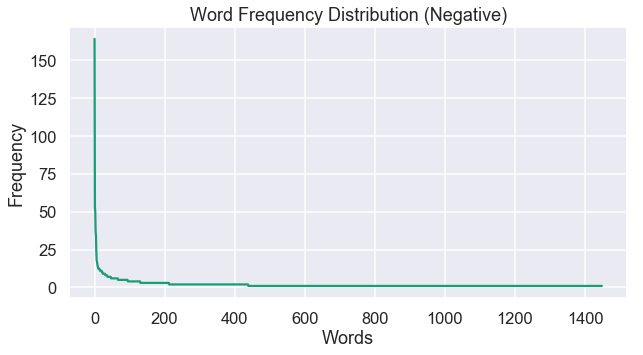

In [59]:
y_val = [x[1] for x in neg_freq.most_common()]

fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative)")
plt.show()

**Visualization:**

**log-log plot:**

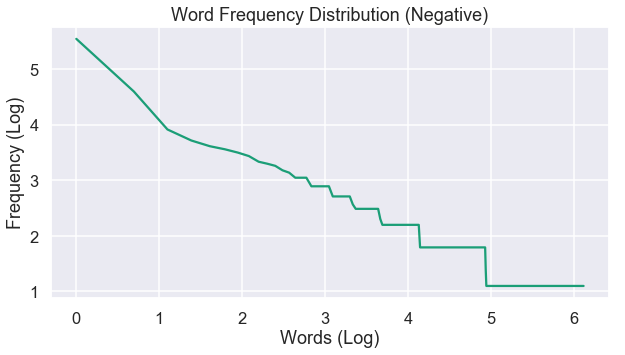

In [58]:
y_final = []
for i, k, z in zip(y_val[0::3], y_val[1::3], y_val[2::3]):
    if i + k + z == 0:
        break
    y_final.append(math.log(i + k + z))

x_val = [math.log(i+1) for i in range(len(y_final))]

fig = plt.figure(figsize=(10,5))

plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Negative)")
plt.plot(x_val, y_final)
plt.show()

Negative distribution fits under the Zipf Law as well. A bit of more smooth slope, but the heavy tail is definitely there. The conclusion to be drawn here, is the exact same as the previous one shown in positive distribution.

***

<p>&nbsp;</p>
<h1 style="text-align: center;"><strong><span lang="pt">CONCLUSION</strong></span></h1>
<p>&nbsp;</p><p>&nbsp;</p><p>&nbsp;</p>

This is a tutorial made by the authors: Nikos Koufos and Brendan Martin, and can be found [here](https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/).

As you can see, the Reddit API makes it extremely easy to compile lots of news data quickly.

I'm using it as a basis to acquire Skills in NLP (Natural Language Processing), since with this model it's so easy to get thousands of sub-line headlines for further analysis and forecasting using [Reddit](https://www.reddit.com/).

**References:**
- [NLTK - Natural Language Toolkit: documentation](http://www.nltk.org/)
- [PRAW: The Python Reddit API Wrapper](https://praw.readthedocs.io/en/latest/index.html)

***

##### INSTALLED VERSIONS

In [28]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.6.6.final.0
python-bits: 64
OS: Windows
OS-release: 10
machine: AMD64
processor: Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
byteorder: little
LC_ALL: None
LANG: None
LOCALE: None.None

pandas: 0.23.4
pytest: 3.9.1
pip: 18.1
setuptools: 40.4.3
Cython: 0.29.1
numpy: 1.15.4
scipy: 1.1.0
pyarrow: None
xarray: None
IPython: 7.0.1
sphinx: 1.8.1
patsy: 0.5.0
dateutil: 2.7.5
pytz: 2018.5
blosc: None
bottleneck: 1.2.1
tables: 3.4.4
numexpr: 2.6.8
feather: None
matplotlib: 2.2.2
openpyxl: 2.5.9
xlrd: 1.1.0
xlwt: 1.3.0
xlsxwriter: 1.1.2
lxml: 4.1.1
bs4: 4.6.3
html5lib: 1.0.1
sqlalchemy: 1.2.14
pymysql: None
psycopg2: None
jinja2: 2.10
s3fs: None
fastparquet: None
pandas_gbq: None
pandas_datareader: None


***